# MD-DTW Analysis Framework  for b9d2 analysis

## Setup: Configure Environment and Import Functions

In [1]:
import os

os.chdir(os.environ['MORPHSEQ_REPO_ROOT']) 

import pandas as pd

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,


    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,

    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,

    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    plot_trajectories_faceted,
    PASTEL_COLORS,

    # K-SELECTION PIPELINE (Phase 1) - SEPARATE FUNCTIONS for granular control
    evaluate_k_range,              # Evaluate multiple k values with metrics
    plot_k_selection,              # Visualize k comparison across all metrics
    classify_membership_2d,        # Core/uncertain/outlier classification

    # Consensus clustering (Phase 2)
    run_consensus_pipeline,        # Full two-stage pipeline
)

# Re-import with new K-medoids functionality
from src.analyze.trajectory_analysis import (
    run_k_selection_with_plots,
    run_bootstrap_kmedoids,
    run_bootstrap_hierarchical,
)

# Import add_membership_column from k_selection module directly
from src.analyze.trajectory_analysis.k_selection import add_membership_column

from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df

from src.analyze.trajectory_analysis import compute_trajectory_distances

from pathlib import Path
results_dir = "results/mcolon/20251219_b9d2_phenotype_extraction"
plot_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/plots")
plot_dir.mkdir(parents=True, exist_ok=True)

print("✓ Imports successful!")

✓ Imports successful!


## Step 1: Load and Filter Data

Load your trajectory data as a long-format DataFrame with columns:
- `embryo_id`: Unique identifier for each embryo
- `predicted_stage_hpf`: Time in hours post fertilization
- Metric columns (e.g., `baseline_deviation_normalized`, `total_length_um`, etc.)
- Optional: `genotype`, `pair`, or other categorical columns for visualization

In [6]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV
# df = pd.read_csv('path/to/your/data.csv')

#Option 2: Use existing data loading utilities

from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe
# List all experiments you want to analyze together
experiment_ids = ['20250512','20251212']  # Add your experiment IDs

# Load and combine
dfs = []
for exp_id in experiment_ids:
    df_exp = load_experiment_dataframe(exp_id, format_version='df03')
    df_exp['experiment_id'] = exp_id  # Track which experiment each row came from
    dfs.append(df_exp)
    print(f"✓ Loaded {exp_id}: {len(df_exp)} rows, {df_exp['embryo_id'].nunique()} embryos")

# Concatenate all experiments
df = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined data: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
print(f"  Experiments: {df['experiment_id'].unique()}")

df = df.loc[df["genotype"].str.contains("cep290", na=False)]

df.loc[df["pair"].isna(), "pair"] = "cep290_spawn"

df["pair"].value_counts(dropna=False)



  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20250512.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20250512.csv
    Curvature: 18720 rows
    Metadata: 9089 rows
    ⚠️  Column divergence detected: ['baseline_deviation_um', 'total_length_um']
    📌 Suffixing: curvature keeps original, metadata gets '_meta'
    Merged on 'snip_id': 9089 rows
    Unique snip_ids: curvature=18720, metadata=9089, merged=9089
    ⚠️  9631 snip_ids only in curvature (dropped)
✓ Loaded 20250512: 9089 rows, 88 embryos
  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251212.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251212

pair
cep290_spawn                  14706
cep290_pair_2_F_pair_2-1_M      896
Name: count, dtype: int64

In [ ]:
valid_embryos = (
    df_homo.loc[df_homo["predicted_stage_hpf"] >= 30, "embryo_id"]
      .unique()
)

df_subset = df_homo[df_homo["embryo_id"].isin(valid_embryos)]

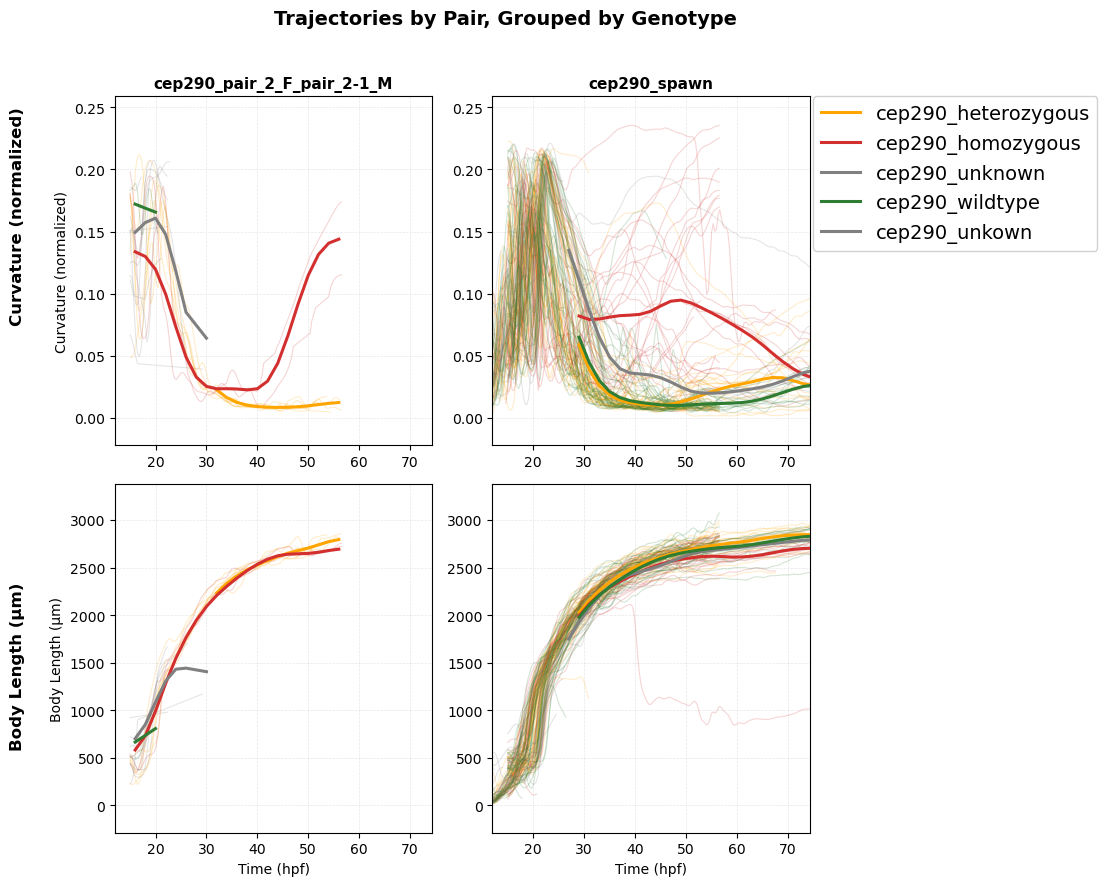

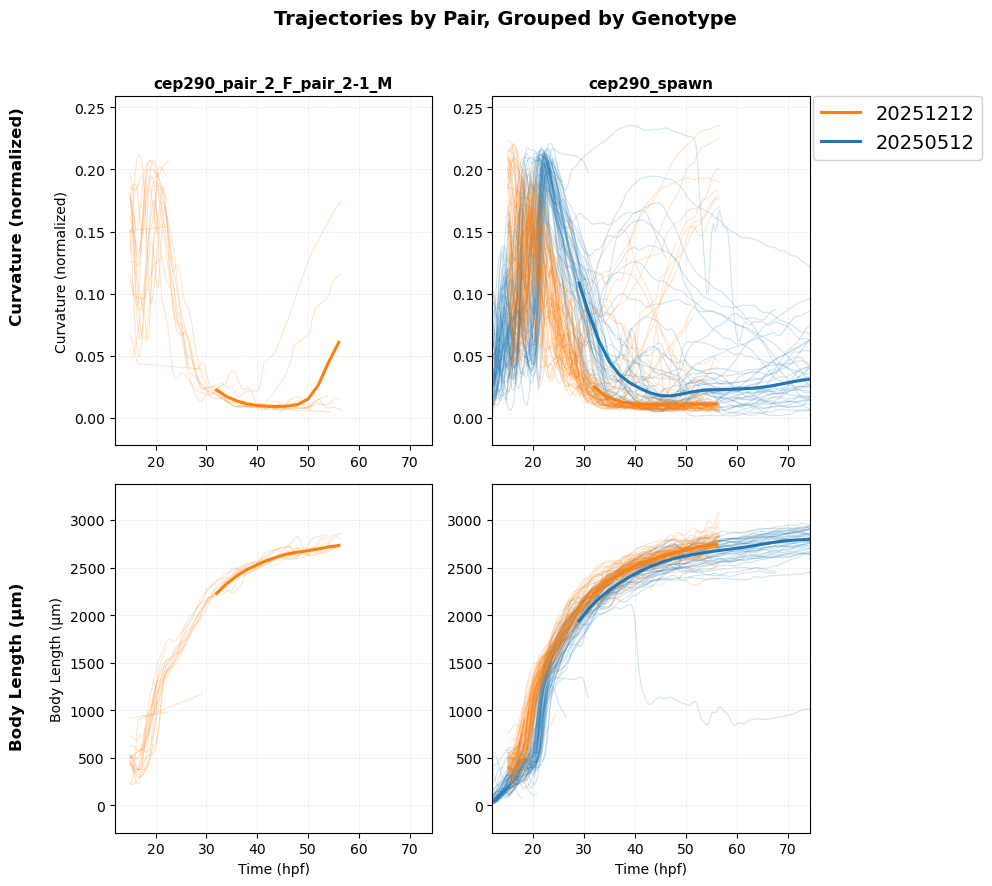

In [7]:
plot_dir = Path('results/mcolon/20251229_cep290_phenotype_extraction/general_plots_early_timepoints')
plot_dir.mkdir(parents=True, exist_ok=True)
    # Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='both',
        bin_width=2.0,
        output_path=plot_dir / 'cep290_trajectories_by_pair_grouped_by_genotype.png'
    )

fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='experiment_id',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='both',
        bin_width=2.0,
        output_path=plot_dir / 'cep290_trajectories_by_pair_grouped_by_experiment_id.png'
    )


In [ ]:
# 1) Filter: penetrant cluster 1 + drop unknown genotypes

# (Optional) sanity check
# print(df_for_plotting[["genotype", "pair"]].value_counts().head(20))
plot_trajectories_faceted(
    df,
    y_col="baseline_deviation_normalized",
    row_by="genotype",
    col_by="experiment_id",
    color_by_grouping="genotype",
    output_path=plot_dir / "cep290_early_experiment_idXgenotype_trajectories.html",
)


## K-SELECTION PIPELINE: Two-Phase Clustering with Membership Quality Assessment

This section integrates the two-phase k-selection pipeline to enable interactive exploration of optimal k and identification of phenotypic clusters.

In [4]:
from src.analyze.trajectory_analysis import compute_trajectory_distances

# Define which metrics to use
metrics = ['baseline_deviation_normalized']

df_homo = df[df["genotype"].astype(str).str.contains("homo", case=False, na=False)].copy()

valid_embryos = (
    df_homo.loc[df_homo["predicted_stage_hpf"] >= 30, "embryo_id"]
      .unique()
)

df_homo = df_homo[df_homo["embryo_id"].isin(valid_embryos)]

# Compute distances using the wrapper function
D_homo, embryo_ids_homo, time_grid = compute_trajectory_distances(
    df_homo,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    sakoe_chiba_radius=20,  # Warping constraint (3 is good default)
    verbose=True
    
)

print(f"\n✓ Distance matrix computed: {D_homo.shape}")
print(f"  Distance range: [{D_homo[D_homo > 0].min():.3f}, {D_homo.max():.3f}]")

COMPUTE TRAJECTORY DISTANCES

1. Using full time range

2. Preparing multivariate array
   Metrics: ['baseline_deviation_normalized']
   Normalize: True
Preparing multivariate array for 1 metrics...
  Metrics: ['baseline_deviation_normalized']
  Normalization: True
  Embryos: 26

Interpolating 1 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (2511, 4)
  Time points: 125 (12.0 - 74.0 hpf)
  Array shape: (26, 125, 1)
  Before normalization:
    baseline_deviation_normalized: mean=0.098, std=0.064
  After normalization:
    baseline_deviation_normalized: mean=0.000000, std=1.000000
✓ Multivariate array prepared successfully

   Array shape: (26, 125, 1) (embryos × timepoints × metrics)
   Time grid: [12.0, 74.0] (125 points)

3. Computing MD-DTW distances
   Sakoe-Chiba radius: 20
Computing MD-DTW distance matrix...
  Embryos: 26
  Array shape: (26, 125, 1)
  Sakoe-Chiba radius: 20
  Parallel jobs: 8 (of 8 CPUs available)
  Computing 325 pairwise distances...

✓ Dist

In [ ]:
# ============================================================================
# PHASE 1: K-SELECTION (Light Filtering)
# ============================================================================
print("="*70)
print("PHASE 1: K-SELECTION (Light Filtering)")
print("="*70)

# Step 1: Light IQR filtering (remove ~8% global outliers)
print("\nStep 1: Light IQR filtering (2.0× multiplier)...")


#NOte to self 
#function here to let you see the metrics and different thresholds would be nice. before selecting IQR, somehting like plot metirc outlier IQr Ranges. 

# Remove outliers and create clean distance matrix for Phase 1
D_homo_filtered, embryo_ids_homo_filtered, filtering_stats = remove_outliers_from_distance_matrix(
    D_homo,
    embryo_ids_homo,
    outlier_detection_method='iqr',
    outlier_threshold=2.0,
    verbose=True
)

PHASE 1: K-SELECTION (Light Filtering)

Step 1: Light IQR filtering (2.0× multiplier)...

Identifying outliers using 'iqr' method...
  Total embryos: 31
  Q1 (25th percentile): 98.421
  Q3 (75th percentile): 129.107
  IQR: 30.686
  IQR multiplier: 1.5×
  Threshold (Q3 + 1.5×IQR): 175.137
  Threshold: 175.137
  Outliers detected: 0
  Inliers retained: 31

✓ Outliers removed
  Original size: (31, 31)
  Clean size: (31, 31)


In [11]:
import pickle 

# Create output directory
data_dir = Path('results/mcolon/20251229_cep290_phenotype_extraction/data')
data_dir.mkdir(parents=True, exist_ok=True)

# Save everything in one comprehensive pickle file
with open(data_dir / 'clustering_data__early_homo.pkl', 'wb') as f:
    pickle.dump({
        # Distance matrix & array
        'D_cep290': D_homo,
        # 'D_cep290_filtered': D_filtered,
        'embryo_ids_cep290': embryo_ids_homo,
        # 'embryo_ids_cep290_filtered': embryo_ids_filtered,
        'time_grid_cep290': time_grid,
        'metrics_cep290': metrics,
        
        # Trajectory DataFrame (most important!)
        'df_cep290_earyltimepoints': df,
        # 'filtering_data':filtering_stats 
    }, f)


In [5]:
# Reload the trajectory_analysis module to pick up changes
import sys

modules_to_remove = [
    'src.analyze.trajectory_analysis',
]
for module in list(sys.modules.keys()):
    if module.startswith('src.analyze.trajectory_analysis'):
        del sys.modules[module]



# Test 1: Quick test that K-medoids function is available
print("✓ run_bootstrap_kmedoids imported successfully")

# Test 2: Run k-selection with K-medoids
# Assuming you have: df, D (distance matrix), embryo_ids already defined
k_results_kmedoids = run_k_selection_with_plots(
    df=df_homo,
    D=D_homo,
    embryo_ids=embryo_ids_homo,
    output_dir=Path('results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data'),
    k_range=[2, 3, 4, 5,6,7],  # Start small for testing
    n_bootstrap=100,      # Fewer iterations for quick test
    method='kmedoids',   # NEW!
    verbose=True
)


✓ run_bootstrap_kmedoids imported successfully
K SELECTION WITH TRAJECTORY PLOTS
Output directory: results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data
Clustering method: kmedoids
Plotting metrics: ['baseline_deviation_normalized', 'total_length_um']
K range: [2, 3, 4, 5, 6, 7]

Evaluating k=2 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 21/26 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

k=2 Summary:
  Core: 25 (96.2%)
  Uncertain: 1 (3.8%)
  Outlier: 0 (0.0%)
  Mean max_p: 0.971
  Mean entropy: 0.121
  Silhouette: 0.551

Evaluating k=3 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 21/26 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/10

In [2]:
import pickle

# Load the first pickle file
with open('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251229_cep290_phenotype_extraction/data/clustering_data__early_homo.pkl', 'rb') as f:
    clustering_data = pickle.load(f)

# Load the second pickle file
with open('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data/k_results.pkl', 'rb') as f:
    k_results_kmedoids = pickle.load(f)

# Display the data
print("Clustering data type:", type(clustering_data))
print("K results type:", type(k_results_kmedoids))

Clustering data type: <class 'dict'>
K results type: <class 'dict'>


In [5]:
clustering_data.keys()

# Unpack the clustering data dictionary
D_homo = clustering_data['D_cep290']
embryo_ids_homo = clustering_data['embryo_ids_cep290']
time_grid_homo = clustering_data['time_grid_cep290']
metrics_homo = clustering_data['metrics_cep290']
df_homo_earyltimepoints = clustering_data['df_cep290_earyltimepoints']
# Load the k-medoids results
with open('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data/k_results.pkl', 'rb') as f:
    k_results_kmedoids = pickle.load(f)

# Display what we loaded
print("Loaded variables:")
print(f"- D_homo: {type(D_homo)}, shape: {D_homo.shape if hasattr(D_homo, 'shape') else 'N/A'}")
print(f"- embryo_ids_homo: {type(embryo_ids_homo)}, length: {len(embryo_ids_homo)}")
print(f"- time_grid_homo: {type(time_grid_homo)}")
print(f"- metrics_homo: {type(metrics_homo)}")
print(f"- df_homo_earyltimepoints: {type(df_homo_earyltimepoints)}, shape: {df_homo_earyltimepoints.shape if hasattr(df_homo_earyltimepoints, 'shape') else 'N/A'}")
print(f"- k_results_kmedoids: {type(k_results_kmedoids)}")

Loaded variables:
- D_homo: <class 'numpy.ndarray'>, shape: (31, 31)
- embryo_ids_homo: <class 'list'>, length: 31
- time_grid_homo: <class 'numpy.ndarray'>
- metrics_homo: <class 'list'>
- df_homo_earyltimepoints: <class 'pandas.core.frame.DataFrame'>, shape: (15602, 297)
- k_results_kmedoids: <class 'dict'>


In [ ]:
from src.analyze.difference_detection import add_group_column, compare_groups, plot_comparison

choosen_k = 3

# cluster 0 is outlier, cluster 1, trends down (is actually two groups though), cluster 2 is high to low,
# i want to do difference detection on 1 vs 3 

# Define your cluster names
cluster_names = {
    0: 'outlier',
    1: 'trends_down',  # Actually two groups
    2: 'high_to_low',
}

# Add cluster labels to DataFrame using k_results
df_homo_with_groups = add_group_column(
    df_homo,
    k_results=k_results_kmedoids,
    k=3,
    cluster_names=cluster_names,
    column_name='cluster_group'
)

cluster_names_k5 = {
    0: 'outlier',
    1: 'bumby',  # Actually two groups
    2: 'low_to_high',
    3: 'low_to_high',
    4: 'high_to_low',
}

# Add cluster labels to DataFrame using k_results
df_homo_with_groups = add_group_column(
    df_homo,
    k_results=k_results_kmedoids,
    k=5,
    cluster_names=cluster_names_k5,
    column_name='cluster_group_k5'
)





In [12]:
 results = compare_groups(
      df_homo_with_groups,
      group_col='cluster_group',
      group1='trends_down',
      group2='high_to_low',
      features='z_mu_b',  # DEFAULT: auto-selects all z_mu_b_0, z_mu_b_1, ... columns
      morphology_metric='baseline_deviation_normalized',
      n_permutations=100,
      verbose=True
  )


Comparing trends_down (n=15) vs high_to_low (n=10)
Using 80 feature columns
  [1/16] Time bin 12 hpf... 

AUROC=0.833, p=0.010
  [2/16] Time bin 16 hpf... AUROC=0.900, p=0.010
  [3/16] Time bin 20 hpf... AUROC=0.607, p=0.366
  [4/16] Time bin 24 hpf... AUROC=0.693, p=0.050
  [5/16] Time bin 28 hpf... AUROC=0.727, p=0.030
  [6/16] Time bin 32 hpf... AUROC=0.807, p=0.010
  [7/16] Time bin 36 hpf... AUROC=0.747, p=0.059
  [8/16] Time bin 40 hpf... AUROC=0.696, p=0.089
  [9/16] Time bin 44 hpf... AUROC=0.773, p=0.050
  [10/16] Time bin 48 hpf... AUROC=0.873, p=0.020
  [11/16] Time bin 52 hpf... AUROC=0.943, p=0.010
  [12/16] Time bin 56 hpf... AUROC=0.955, p=0.010
  [13/16] Time bin 60 hpf... skipped (need 2 classes, got 1)
  [14/16] Time bin 64 hpf... skipped (need 2 classes, got 1)
  [15/16] Time bin 68 hpf... skipped (need 2 classes, got 1)
  [16/16] Time bin 72 hpf... skipped (need 2 classes, got 1)


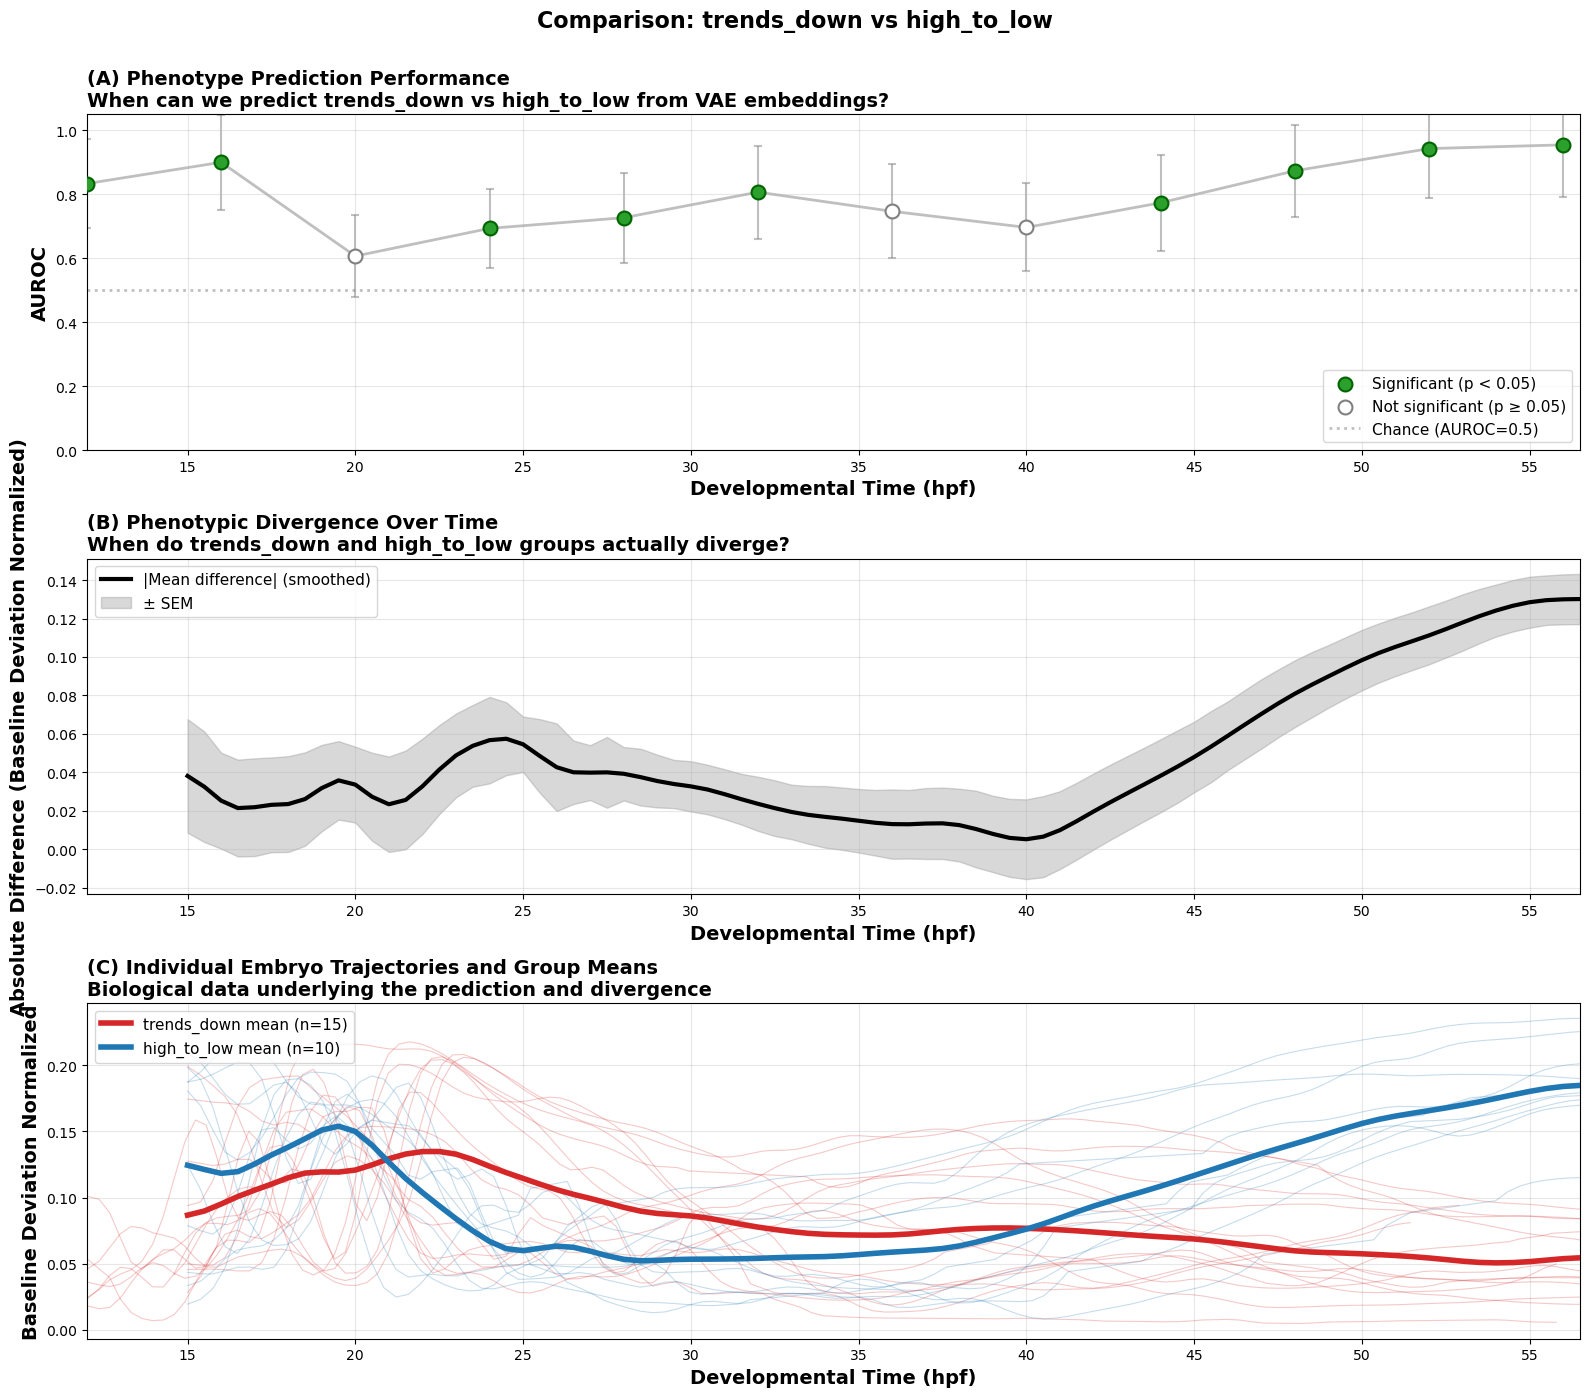

In [13]:
plot_dir = Path("results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data")

# Plot the results
fig = plot_comparison(df_homo_with_groups, results)
fig.savefig(plot_dir / 'trends_down_vs_high_to_low_comparison_k=3.png')

In [ ]:

# Add cluster labels to DataFrame using k_results
df_homo_with_groups = add_group_column(
    df_homo,
    k_results=k_results_kmedoids,
    k=5,
    cluster_names=cluster_names_k5,
    column_name='cluster_group_k5'
)


 results = compare_groups(
      df_homo_with_groups,
      group_col='cluster_group',
      group1='trends_down',
      group2='high_to_low',
      features='z_mu_b',  # DEFAULT: auto-selects all z_mu_b_0, z_mu_b_1, ... columns
      morphology_metric='baseline_deviation_normalized',
      n_permutations=100,
      verbose=True
  )

plot_dir = Path("results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data/k_5")

# Plot the results
fig = plot_comparison(df_homo_with_groups, results)
# Reload the plotting module to get the bug fix
  import importlib
  import sys

  # Remove the module from cache if it exists
  if 'src.analyze.difference_detection.plotting' in sys.modules:
      del sys.modules['src.analyze.difference_detection.plotting']

  # Reimport
  from src.analyze.difference_detection import plot_comparison

  # Now run your plotting code again
  fig = plot_comparison(df_homo_with_groups, results)
  outpath = plot_dir / f"{group1}_vs_{group2}_comparison_k5.png"
  fig.savefig(outpath, dpi=300, bbox_inches="tight")
  print(f"Saved: {outpath}")
fig.savefig(plot_dir / 'trends_down_vs_high_to_low_comparison_k=5.png')

In [20]:
# Restart the kernel OR use this aggressive reload:
import sys
import importlib
import matplotlib.pyplot as plt
# Step 1: Remove ALL analyze modules from cache
modules_to_remove = [k for k in list(sys.modules.keys()) if 'analyze' in k or 'difference_detection' in k]
for mod in modules_to_remove:
    del sys.modules[mod]

# Step 2: Reimport from scratch
from src.analyze.difference_detection import add_group_column, compare_groups, plot_comparison

# Step 3: Verify the fix is loaded by checking the source
import inspect
source = inspect.getsource(plot_comparison)
if 'if not classification_df.empty:' in source:
    print("✓ Bug fix is loaded!")
else:
    print("✗ Still using old version - please restart kernel")


group_col = "cluster_group_k5"

non_outlier_groups = (
    df_homo_with_groups[group_col]
    .dropna()
    .unique()
)

# Optional: explicitly remove outliers if present
non_outlier_groups = [
    g for g in non_outlier_groups
    if "outlier" not in str(g).lower()
]

print("Non-outlier groups:", non_outlier_groups)


from itertools import combinations

plot_dir = Path(
    "results/mcolon/20251229_cep290_phenotype_extraction/"
    "kmedoids_k_selection_early_timepoints_cep290_data/k_5"
)
plot_dir.mkdir(parents=True, exist_ok=True)

for group1, group2 in combinations(non_outlier_groups, 2):

    print(f"\n=== Comparing {group1} vs {group2} ===")

    results = compare_groups(
        df_homo_with_groups,
        group_col=group_col,
        group1=group1,
        group2=group2,
        features="z_mu_b",
        morphology_metric="baseline_deviation_normalized",
        n_permutations=100,
        verbose=True,
    )

    fig = plot_comparison(df_homo_with_groups, results)

    outpath = plot_dir / f"{group1}_vs_{group2}_comparison_k5.png"
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.close(fig)

✓ Bug fix is loaded!
Non-outlier groups: ['high_to_low', 'bumby', 'low_to_high']

=== Comparing high_to_low vs bumby ===
Comparing high_to_low (n=4) vs bumby (n=8)
Using 80 feature columns
  [1/16] Time bin 12 hpf... skipped (min class has 4 samples, need 5)
  [2/16] Time bin 16 hpf... skipped (min class has 4 samples, need 5)
  [3/16] Time bin 20 hpf... skipped (min class has 4 samples, need 5)
  [4/16] Time bin 24 hpf... skipped (min class has 4 samples, need 5)
  [5/16] Time bin 28 hpf... skipped (min class has 4 samples, need 5)
  [6/16] Time bin 32 hpf... skipped (min class has 4 samples, need 5)
  [7/16] Time bin 36 hpf... skipped (min class has 4 samples, need 5)
  [8/16] Time bin 40 hpf... skipped (min class has 4 samples, need 5)
  [9/16] Time bin 44 hpf... skipped (min class has 4 samples, need 5)
  [10/16] Time bin 48 hpf... 

skipped (min class has 4 samples, need 5)
  [11/16] Time bin 52 hpf... skipped (min class has 4 samples, need 5)
  [12/16] Time bin 56 hpf... skipped (min class has 4 samples, need 5)
  [13/16] Time bin 60 hpf... skipped (min class has 3 samples, need 5)
  [14/16] Time bin 64 hpf... skipped (min class has 3 samples, need 5)
  [15/16] Time bin 68 hpf... skipped (min class has 3 samples, need 5)
  [16/16] Time bin 72 hpf... skipped (min class has 3 samples, need 5)

=== Comparing high_to_low vs low_to_high ===
Comparing high_to_low (n=4) vs low_to_high (n=13)
Using 80 feature columns
  [1/16] Time bin 12 hpf... skipped (min class has 4 samples, need 5)
  [2/16] Time bin 16 hpf... skipped (min class has 4 samples, need 5)
  [3/16] Time bin 20 hpf... skipped (min class has 4 samples, need 5)
  [4/16] Time bin 24 hpf... skipped (min class has 4 samples, need 5)
  [5/16] Time bin 28 hpf... skipped (min class has 4 samples, need 5)
  [6/16] Time bin 32 hpf... skipped (min class has 4 samples,

In [14]:
k_results_kmedoids["clustering_by_k"][5].keys()

dict_keys(['quality', 'assignments', 'membership', 'posteriors', 'bootstrap_results', 'classification'])

Cluster distribution:
cluster
low_to_high    1234
bumby           857
high_to_low     754
outlier         195
Name: count, dtype: int64

Unique clusters: ['bumby', 'high_to_low', 'low_to_high', 'outlier']


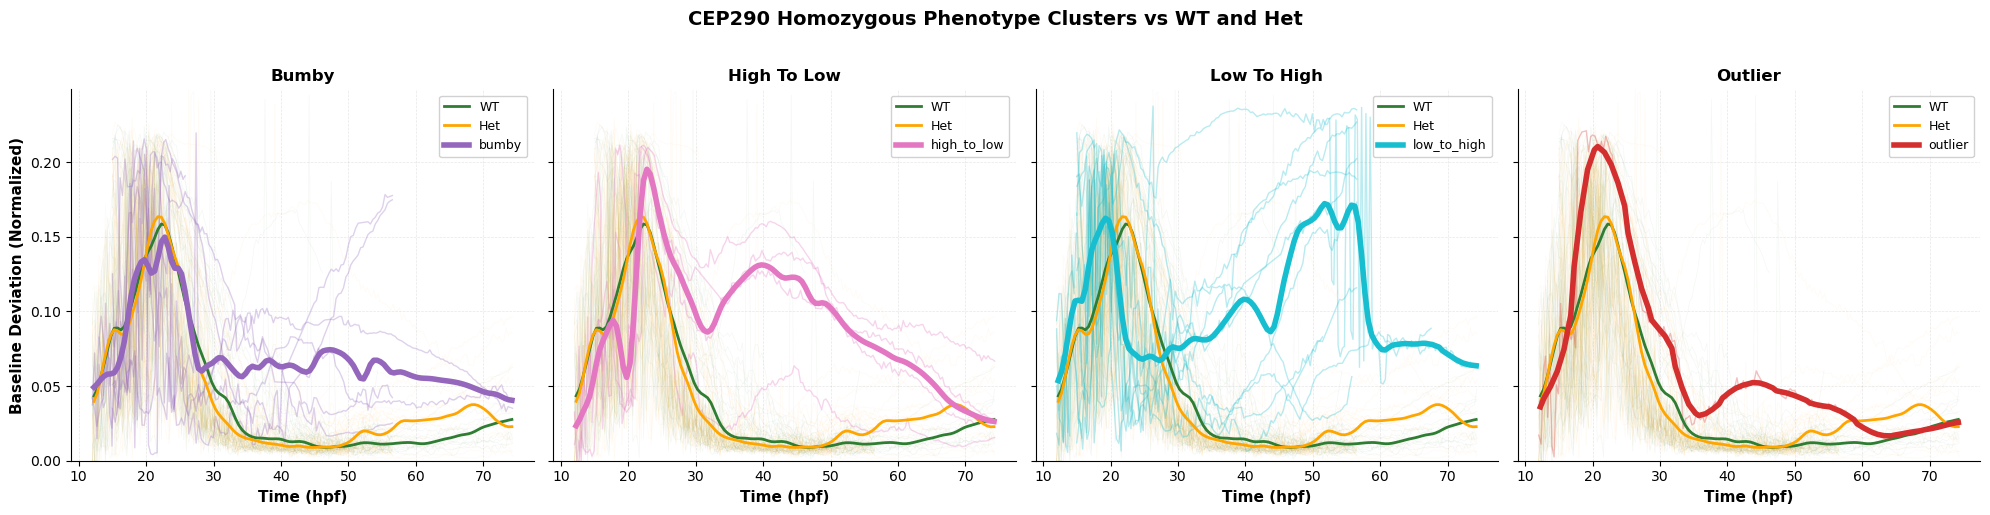

In [21]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load the clustering data
with open('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251229_cep290_phenotype_extraction/data/clustering_data__early_homo.pkl', 'rb') as f:
    clustering_data = pickle.load(f)

# Unpack
D_cep290 = clustering_data['D_cep290']
embryo_ids_cep290 = clustering_data['embryo_ids_cep290']
time_grid_cep290 = clustering_data['time_grid_cep290']
metrics_cep290 = clustering_data['metrics_cep290']
df = clustering_data['df_cep290_earyltimepoints']

# Load k-medoids results
with open('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251229_cep290_phenotype_extraction/kmedoids_k_selection_early_timepoints_cep290_data/k_results.pkl', 'rb') as f:
    k_results_kmedoids = pickle.load(f)

# Extract cluster assignments for k=5
cluster_labels = k_results_kmedoids['clustering_by_k'][5]['assignments']['cluster_labels']

# Define cluster names
cluster_names_k5 = {
    0: 'outlier',
    1: 'bumby',
    2: 'low_to_high',
    3: 'low_to_high',
    4: 'high_to_low',
}

# Create a mapping from embryo_id to cluster name
embryo_cluster_map = {}
for embryo_id, cluster_id in zip(embryo_ids_cep290, cluster_labels):
    embryo_cluster_map[embryo_id] = cluster_names_k5[cluster_id]

# Add cluster column to homozygous embryos
df['cluster'] = None
homo_mask = df['genotype'].str.contains('homo', case=False, na=False)
df.loc[homo_mask, 'cluster'] = df.loc[homo_mask, 'embryo_id'].map(embryo_cluster_map)

# Check distribution
print("Cluster distribution:")
print(df[homo_mask]['cluster'].value_counts())

# Define colors
COLORS = {
    'cep290_wildtype': '#2E7D32',      # Green
    'cep290_wt': '#2E7D32',            # Green
    'cep290_heterozygous': '#FFA500',  # Orange
    'cep290_het': '#FFA500',           # Orange
    'outlier': '#D32F2F',              # Red
    'bumby': '#9467BD',                # Purple
    'low_to_high': '#17BECF',          # Cyan
    'high_to_low': '#E377C2',          # Pink
}

# Helper function to compute trend line
def compute_trend_line(df_subset, x_col='predicted_stage_hpf', y_col='baseline_deviation_normalized', 
                        bin_width=0.5, smooth_sigma=1.5):
    """Compute binned median trend line with smoothing."""
    times = df_subset[x_col].values
    metrics = df_subset[y_col].values

    # Remove NaNs
    mask = ~(np.isnan(times) | np.isnan(metrics))
    times = times[mask]
    metrics = metrics[mask]

    if len(times) == 0:
        return None, None

    # Create bins
    t_min, t_max = times.min(), times.max()
    bins = np.arange(t_min, t_max + bin_width, bin_width)

    if len(bins) < 2:
        return None, None

    # Assign to bins and compute median
    bin_indices = np.digitize(times, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(bins) - 2)

    bin_times = []
    bin_medians = []

    for i in range(len(bins) - 1):
        bin_mask = bin_indices == i
        bin_values = metrics[bin_mask]

        if len(bin_values) >= 2:
            bin_center = (bins[i] + bins[i + 1]) / 2
            bin_times.append(bin_center)
            bin_medians.append(np.median(bin_values))

    if len(bin_times) == 0:
        return None, None

    bin_times = np.array(bin_times)
    bin_medians = np.array(bin_medians)

    # Apply gaussian smoothing
    if smooth_sigma and len(bin_medians) > 3:
        bin_medians = gaussian_filter1d(bin_medians, sigma=smooth_sigma)

    return bin_times, bin_medians

# Get unique cluster names (excluding None)
unique_clusters = [c for c in df[homo_mask]['cluster'].unique() if c is not None and pd.notna(c)]
unique_clusters = sorted(unique_clusters)
print(f"\nUnique clusters: {unique_clusters}")

# Create figure with subplots
n_clusters = len(unique_clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)

if n_clusters == 1:
    axes = [axes]

# Get global y-limits
y_col = 'baseline_deviation_normalized'
x_col = 'predicted_stage_hpf'
y_min = df[y_col].min()
y_max = df[y_col].max()

# Plot each cluster in its own facet
for idx, cluster_name in enumerate(unique_clusters):
    ax = axes[idx]

    # 1. Plot WT individual trajectories (faded green in background)
    wt_df = df[df['genotype'].str.contains('wildtype|wt', case=False, na=False)]
    for embryo_id in wt_df['embryo_id'].unique():
        embryo_data = wt_df[wt_df['embryo_id'] == embryo_id].sort_values(x_col)
        ax.plot(embryo_data[x_col], embryo_data[y_col],
                color=COLORS['cep290_wildtype'], alpha=0.05, linewidth=0.5, zorder=1)

    # 2. Plot het individual trajectories (faded orange in background)
    het_df = df[df['genotype'].str.contains('het', case=False, na=False)]
    for embryo_id in het_df['embryo_id'].unique():
        embryo_data = het_df[het_df['embryo_id'] == embryo_id].sort_values(x_col)
        ax.plot(embryo_data[x_col], embryo_data[y_col],
                color=COLORS['cep290_heterozygous'], alpha=0.05, linewidth=0.5, zorder=1)

    # 3. Plot this cluster's individual trajectories (faded cluster color)
    cluster_df = df[df['cluster'] == cluster_name]
    cluster_color = COLORS.get(cluster_name, '#808080')
    for embryo_id in cluster_df['embryo_id'].unique():
        embryo_data = cluster_df[cluster_df['embryo_id'] == embryo_id].sort_values(x_col)
        ax.plot(embryo_data[x_col], embryo_data[y_col],
                color=cluster_color, alpha=0.3, linewidth=1.0, zorder=2)

    # 4. Plot WT trend line (bold green)
    wt_times, wt_trend = compute_trend_line(wt_df, x_col, y_col)
    if wt_times is not None:
        ax.plot(wt_times, wt_trend, color=COLORS['cep290_wildtype'],
                linewidth=2.0, label='WT', zorder=5)

    # 5. Plot het trend line (bold orange)
    het_times, het_trend = compute_trend_line(het_df, x_col, y_col)
    if het_times is not None:
        ax.plot(het_times, het_trend, color=COLORS['cep290_heterozygous'],
                linewidth=2.0, label='Het', zorder=5)

    # 6. Plot this cluster's trend line (bold cluster color)
    cluster_times, cluster_trend = compute_trend_line(cluster_df, x_col, y_col)
    if cluster_times is not None:
        ax.plot(cluster_times, cluster_trend, color=cluster_color,
                linewidth=4.0, label=cluster_name, zorder=6)

    # Styling
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Time (hpf)', fontsize=11, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('Baseline Deviation (Normalized)', fontsize=11, fontweight='bold')
    ax.set_title(f'{cluster_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Overall title
fig.suptitle('CEP290 Homozygous Phenotype Clusters vs WT and Het',
            fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Save if desired
fig.savefig('cep290_cluster_faceted_trajectories.png', dpi=150, bbox_inches='tight')

In [ ]:
plot_trajectories_faceted(
    df,
    y_col="baseline_deviation_normalized",
    row_by="genotype",
    col_by="experiment_id",
    color_by_grouping="genotype",
    output_path=plot_dir / "cep290_early_experiment_idXgenotype_trajectories.html",
)
